# Tabular Playground Series - March 2021
In this kernal, I have dealt with a combination of continous and categorical data to predict targets of a categorical type. The main techniques I have used in this kernel include:
* Binary Encoding
* Hyperparameter Tuning using GridSearch
* Gradient Boosting Classifier

**SCORE: 0.7535**

Some ideas to improve this kernel:
* Feature Engineering (difficult to do due to stochastic nature of data)
* Bayesian Classification by studying distribution of continuous features?
* Upgrading Gradient Boost by using LightGBM or XGBoost
* Deeper hypertuning of model (especially if upgraded to LightGBM ot XGBoost)

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

data = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')
test_data = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
data = data.iloc[:,1:]
test_data_id = test_data.iloc[:,0]
data_target = data.iloc[:,-1]

After inputting the data, it is seperated into categorical and continous dataframes

In [4]:
cat_columns = []
cont_columns = []
for column in data.columns:
    if data[column].dtype == object:
        cat_columns.append(column)
    else:
        cont_columns.append(column)
print(cat_columns,'\n', cont_columns)

['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18'] 
 ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target']


In [5]:
cat_data = data.loc[:,cat_columns]
cont_data = data.loc[:,cont_columns]
cat_test = test_data.loc[:,cat_columns]
cont_test = test_data.loc[:,cont_columns[:-1]]

Now that the data has been seperated according to its type, the categorical data has been encoded using binary encoding so that it may be fed into an sklearn model (in this case Gradient Boosting Classifier) 

In [6]:
from category_encoders import BinaryEncoder
bin_enc = BinaryEncoder()
cat_data = bin_enc.fit_transform(cat_data)
cat_test = bin_enc.fit_transform(cat_test)
cat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 78 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   cat0_0   200000 non-null  int64
 1   cat0_1   200000 non-null  int64
 2   cat1_0   200000 non-null  int64
 3   cat1_1   200000 non-null  int64
 4   cat1_2   200000 non-null  int64
 5   cat1_3   200000 non-null  int64
 6   cat2_0   200000 non-null  int64
 7   cat2_1   200000 non-null  int64
 8   cat2_2   200000 non-null  int64
 9   cat2_3   200000 non-null  int64
 10  cat2_4   200000 non-null  int64
 11  cat3_0   200000 non-null  int64
 12  cat3_1   200000 non-null  int64
 13  cat3_2   200000 non-null  int64
 14  cat3_3   200000 non-null  int64
 15  cat4_0   200000 non-null  int64
 16  cat4_1   200000 non-null  int64
 17  cat4_2   200000 non-null  int64
 18  cat4_3   200000 non-null  int64
 19  cat4_4   200000 non-null  int64
 20  cat5_0   200000 non-null  int64
 21  cat5_1   200000 non-null  int64
 

The data is fed into a tool from the pandas_profiling library which creates an extensive statistical report with the continous data 

In [ ]:
import pandas_profiling as pp
profile = pp.ProfileReport(cont_data)
profile.to_file('profile')

A heatmap is created just to check if any of the columns are especially strongly correlated with the target and to also study the correlation patterns between the columns themselves

In [ ]:
ax = sb.heatmap(cont_data.corr(),vmin = -1, vmax = 1, center = 0, cmap = sb.diverging_palette(20, 220, n=256))

The continous and categorical data that have been seperated for EDA and data processing are now concatenated back together to be fed into the final model

In [8]:
data = pd.concat([cat_data,cont_data.iloc[:,:-1]], axis = 1)
test_data = pd.concat([cat_test,cont_test],axis = 1)

The train test split function is used to split the data into 3 sets:
* Tuning Set
* Training Set
* Validation Set

In [9]:
from sklearn.model_selection import train_test_split
dummy,X_tune,dummy,y_tune = train_test_split(data, data_target, stratify = data_target, test_size = 0.1)
X_train,X_val,y_train,y_val = train_test_split(data, data_target, stratify = data_target, test_size = 0.3)

Grid search is implemented across the various parameters stored in 'param_grid' and the optimal parameters are finalized.

In [ ]:
param_grid = {'max_depth': [2,3,4], 'n_estimators': [20,25], 'learning_rate' : [0.2,0.3,0.4]}
gbc = GradientBoostingClassifier()
g_search = GridSearchCV(gbc,param_grid, cv = 3)
g_search.fit(X_tune,y_tune)
print('Optimal Parameters are: ', g_search.best_params_, '\n'
     'Corresponding Score: ', g_search.best_score_)

The optimal parameters from the grid search tuning procedure can then be used in the final model that is trained below

In [ ]:
gbc = GradientBoostingClassifier(max_depth = 4, learning_rate = 0.2, n_estimators = 25)

gbc.fit(X_train,y_train)
y_pred = gbrt.predict(X_val)

Since this is a classification problem, it would be appropriate to determine the effectiveness of the model on the validation data set, this can be used in the future to further tune some hyperparameters of the model or in an extreme case move to a model that may be better suited to the datset.

In [39]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
precision = []
recall = []
fscore = []
for i in range(1,20):
    gbc = GradientBoostingClassifier(max_depth = 4, learning_rate = 1, n_estimators = i)
    gbc.fit(X_train,y_train)
    y_pred = gbc.predict(X_val)
    prec,rec,fs,_ = precision_recall_fscore_support(y_val,y_pred)
    precision.append(prec[1])
    recall.append(rec[1])
    fscore.append(fs[1])
precision = np.round_(precision, decimals = 3)
recall = np.round_(recall, decimals = 3)
fscore = np.round_(fscore, decimals = 3)

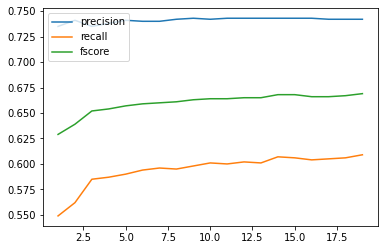

In [40]:
plt.plot(range(1,20),precision, label = 'precision')
plt.plot(range(1,20),recall,label = 'recall')
plt.plot(range(1,20),fscore, label = 'fscore')
plt.legend(loc = 'upper left')
plt.show()


In [ ]:
precision,recall,fscore,_ = precision_recall_fscore_support(y_val,y_pred)
print('precision: ', precision, '\n' 
     'recall: ', recall, '\n'
     'fscore:', fscore )

Finally, once the model and its hyper parameters are finalized, they can be used to create a csv file with the output from the test dataset. This output can then be submitted to the kaggle competition for a score.

In [ ]:
output = pd.DataFrame(data = gbrt.predict(test_data), columns = ['target'])
output = pd.concat([test_data_id,output],axis = 1)
output.head()
output.to_csv('submission.csv',index = False)